# Livrable final data science

### Contexte

L'entreprise TouNum est une entreprise de numérisation de documents. Elle prospose différents services dont la numérisation de base de document papier pour les entreprises clientes. TouNum veut optimiser et rendre intelligent ce processus de scanning en incluant des outils de Machine Learning. Le gain de temps serait important aux vues des nombreuses données que l'entreprise doit scanner et étiqueter.
Pour cela, TouNum fait appel à CESI pour réaliser cette prestation.

### Objectif

L'objectif est que l'équipe de data scientist de CESI réalise cette solution visant à analyser des photographies pour en déterminer une légende descriptive de manière automatique. Il faudra également améliorer la qualité des images scannées ayant des qualités variables (parfois floues, ou bruitées).

<img src="imageSrc/caption image.PNG"/>

### Enjeux

TouNum devait trier et étiqueter chaque document scanné. La solution délivré par CESI permet l'automatisation de ces tâches en faisant donc gagner un temps non négligeable. Elle va donc pouvoir réaliser plus de contrats et augmenter la satisfaction client.

### Contraintes techniques

L'implémentation des algorithmes doit être réaliser sur Python, notamment les librairies Scikit et TensorFlow. La librairie Pandas doit être utilisé pour manipuler le dataset et ImageIO pour le charger. NumPy et MatPlotLib seront nécessaire pour le calcul scientifique et la modélisation.

Le programme à livrer devra respecter le workflow suivant :

<img src="imageSrc/workflow.PNG"/>

#### Classification:

La classification d'image se fera à l'aide de réseaux de neurones. Cette dernière doit distinguer les photos d'un autre documents, tel que schémas, textes scannés, voir peintures.
TouNoum possède un dataset rempli d'images divers pour entrainer le réseau de neurones.

#### Prétraitement

Le prétraitement dois utiliser des filtres convolutifs afin d'améliorer la qualité. Il doit établir un compromis entre débruitage et affutage.

#### Captionning

Le Captionning devra légender automatiquement les images. Il utilisera deux techniques de Machine Learning : les réseaux de neurones convolutifs (CNN) pour prétraiter l'image en identifiant les zones d’intérêt, et les réseaux de neurones récurrents (RNN) pour générer les étiquettes. Il faudra être vigilant quant aux ressources RAM. Un dataset d'étiquetage classique est disponible pour l’apprentissage supervisé.

### Livrable

La solution doit sous forme de notebook Jupiter entièrement automatisé. Il doit être conçu pour être faciliter mis en production et maintenance.
Il faut démontrer la pertinence du modèle de manière rigoureuse et pédagogique.

#### Jalons

CESI devra dois rendre le prototype complet et fonctionnel du programme pour le 23 janvier. 
TouNum exige également 3 dates de rendu pour suivre la bonne avancé du projet.
<ul>
    <li>18/12/20 : Prétraitement d'image</li>
    <li>15/01/21 : Classification binaire</li>
    <li>20/01/21 : Captioning d'images</li>
    <li>22/01/21 : Démonstration </li>
</ul>


### *Importation des librairies utilisées*

In [49]:
import os
import time
import random

# Check if imageio package is installed
try:
    import imageio
except ImportError:
    !pip install imageio
    
import imageio
import matplotlib.pyplot as plt
import numpy as np

# Check if cikit-image package is installed
try:
    import skimage
except ImportError:
    !pip install scikit-image

from skimage import io
from skimage.restoration import estimate_sigma

# Check if opencv-python package is installed
try:
    import cv2
except ImportError:
    !pip install opencv-python

import cv2

import threading
from queue import Queue
from multiprocessing import Pool

import pathlib

# Check if pandas package is installed
try:
    import pandas
except ImportError:
    !pip install pandas

import pandas as pd

# Livrable 2
import PIL
import PIL.Image

# Check if tensorflow package is installed
try:
    import tensorflow
except ImportError:
    !pip install tensorflow

# Check if tensorflow_datasets package is installed
try:
    import tensorflow_datasets
except ImportError:
    !pip install tensorflow_datasets    


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

# Check if tensorflow_datasets package is installed
try:
    import keras
except ImportError:
    !pip install keras    
from keras.preprocessing import image
from keras import backend as K

# Livrable 3 
import json
import collections

from PIL import Image

# Check if tqdm package is installed
try:
    import tqdm
except ImportError:
    !pip install -q tqdm

from tqdm import tqdm

import shutil

### *Chemins physiques*

In [68]:
#Livrable 2
classification_dataset_path = "./Dataset/2/dataset/"
classification_model_path = "./Models/classification/"
classification_input_path = './Dataset/2/input/'
classification_output_path = './Dataset/2/output/'

# Livrable 1
blurry_dataset_path = "./Dataset/1/dataset/Blurry/"
noisy_dataset_path = "./Dataset/1/dataset/Noisy/"
deblured_dataset_path = "./Dataset/1/dataset/deblurred/"
denoised_dataset_path = "./Dataset/1/dataset/denoised/"
treatments_output_path = './Dataset/1/output/'

#Livrable 3
captioning_output_path = './Dataset/3/output'

## Livrable 2 - Classification binaire

In [3]:
#basics checks for image classifications
print("executing tensorflow version " + tf.__version__)

if (len(tf.config.experimental.list_physical_devices('GPU')) == 1):
    print("GPU is detected")
else :
    print("GPU isn't detected")

executing tensorflow version 2.3.0
GPU is detected


In [7]:
#Parameters for the dataset (amount of images per batch, image resolution and training percentage)
batch_size = 16
img_height = 200
img_width = 200
validation_split = 0.2

epochs=15
classes = ['Other', 'Photo']

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def generate_model():
    #generation of the training dataset
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      classification_dataset_path,
      validation_split=validation_split,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    #generation of the validation dataset
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      classification_dataset_path,
      validation_split=validation_split,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    #retrieve the amount of classes for the model
    num_classes = len(train_ds.class_names)
    print("Classes found : " + str(num_classes))
    print(train_ds.class_names)

    #Allow for perfomance compilation times by preventing IO bottleneck on disks while compiling the model
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    #Structure of the neural network
    model = tf.keras.Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dense(128, activation='relu'),
      layers.GlobalAveragePooling2D(),
      layers.Dropout(0.2),
      layers.Dense(2)
    ])
    
    #display neural network structure
    model.summary()

    #compile the model
    model.compile(
        optimizer='adam',
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
        #metrics=['accuracy', get_f1])
    
    #amount of training and fitting
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
    
    #display statitics over training accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    return model

def classify_image(model, classes, impath):
    #load disj image
    img = image.load_img((impath), target_size=(img_height, img_width))
    img  = image.img_to_array(img)
    img  = img.reshape((1,) + img.shape)

    #use model to predict classe
    prediction = model.predict(img)
    score = tf.nn.softmax(prediction[0])
    #     print(
    #         "This image most likely belongs to {} with a {:.2f} percent confidence."
    #         .format(classes[np.argmax(score)], 100 * np.max(score))
    #     )
    #return clas and percentage of confidence
    return [classes[np.argmax(score)], 100 * np.max(score)]

In [8]:
def get_model(newModel=False):
    # Checking if the Models folder is empty
    if newModel == True: 
        model = generate_model()
        tf.keras.models.save_model(model, classification_model_path)
        return model    
    # Or not
    else:
        return tf.keras.models.load_model(classification_model_path)
    
model = get_model(False)


In [70]:
# confidence threshold about consider a image as a photo
confidence_threshold = 60

# Classify images and moved "Photo" to the output folder 
for pictures in os.listdir(classification_input_path):
    res_classe, res_score = classify_image(model, classes, os.path.join(classification_input_path,pictures))
    
    print(pictures, res_classe, res_score, '%')

    if (res_classe == 'Photo' and res_score > confidence_threshold):
        shutil.copy2(classification_input_path + "/" + pictures, classification_output_path) 



013_1_1_sz1.jpg Other 98.37130308151245 %
047_1_1_sz1.jpg Other 98.12994599342346 %
128.png Other 100.0 %
129.png Other 100.0 %
134_1_1_sz1.jpg Other 96.56375050544739 %
42.png Other 99.99719858169556 %
photo_0077.jpg Photo 71.0858166217804 %
photo_0193.jpg Photo 92.31694340705872 %
photo_0197.jpg Photo 95.69118618965149 %
photo_0292.jpg Photo 73.42495918273926 %
photo_0364.jpg Photo 81.79098963737488 %
photo_0499.jpg Photo 99.46569204330444 %
photo_0619.jpg Photo 99.99792575836182 %


# Livrable 1 - Prétraitement (denoising/sharpening…)

In [16]:
# Deblurring function
def remove_blur(img, high):
    kernel = []
    
    if high:
        # Creation of a Laplacian kernel to use for debluring
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    else:
        kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    
    # Convolution of the kernel with the image given in the function's parameter
    return cv2.filter2D(img, -1, kernel)

def get_blurry_indicator(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return fm

# Thread execution
def process_fpath(name):
    path = classification_output_path + name
    img = get_image(classification_output_path,name)

     # Get initial Blur metric
    #original_blur_metric = get_blurry_indicator(img)
    #pre_processed_data.append(original_blur_metric)
    
    # Remove blur from the colored image image
    deblurred_img = remove_blur(img, high=True)

    # Get initial Blur metric
    #processed_blur_metric = get_blurry_indicator(deblurred_img)
    #post_processed_data.append(processed_blur_metric)
    
    #print("image " + name + " - initial : " + str(original_blur_metric)
     #   + " - processed : " + str(processed_blur_metric)
     #   + " - difference : " + str(processed_blur_metric - original_blur_metric)+"\n")

    #data_preview_blurr.append([name, original_blur_metric, processed_blur_metric])

    # Saving Image
    save_image(treatments_output_path, name, deblurred_img)
    
# Remove Noise function
def remove_noise(image, high):
    if high == 2:
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)
    elif high == 1:
        return cv2.fastNlMeansDenoisingColored(image, None, 5, 10, 7, 15)
    else:
        return cv2.fastNlMeansDenoisingColored(image, None, 3, 3, 7, 15)

def estimate_noise(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return estimate_sigma(img)

# Thread execution
def process_fpath(name):
    path = noisy_dataset_path + name
    img = get_image(noisy_dataset_path,name)
    
    # Get initial noise metric
    original_noise_metric = estimate_noise(img)
    pre_processed_data.append(original_noise_metric)
    
    denoised_img = remove_noise(img, high=2)
    
    # Get initial noise metric
    processed_noise_metric = estimate_noise(denoised_img)
    post_processed_data.append(processed_noise_metric)

    data_preview_denoised.append([name, original_noise_metric, processed_noise_metric])
    
    save_image(denoised_dataset_path, name, denoised_img)

## Optimisation entre Défloutage et Débruitage

In [89]:
def get_image(path, filename):
    return io.imread(path + filename)

def save_image(path, filename, content):
    #Check if folder exists
    if not os.path.isdir(path):
        os.makedirs(path)
    imageio.imwrite(path + filename , content)

def clear_image(img):
        
    #if you want random testing
    img = get_image(classification_output_path, img)

    #initial image measurements
    initial_noise = estimate_noise(img)
    initial_blur = get_blurry_indicator(img)
    # print(initial_noise, initial_blur)
    #print(initial_noise)
    #print(initial_blur)
    #image is blurry
    if initial_blur < 3000:
        print('too much blur')
        # high deblur of the image
        img = remove_blur(img, high=False)

        #second image measurements
        second_noise = estimate_noise(img)
        second_blur = get_blurry_indicator(img)

        #image doesn't meets requirements in terms of noise
        if second_noise > 2:
            #low denoise of the image
            img = remove_noise(img, 0)

            img = remove_noise(img, 0)

    #if image is noisy      
    elif initial_noise > 0.8:
        print('too much noise')
        # high denoise of the image
        img = remove_noise(img, 1)

        #second image measurements
        second_noise = estimate_noise(img)
        second_blur = get_blurry_indicator(img)

        #image meets requirements in terms of blur
        if second_blur < 48000:
            #low deblur of the image
            img = remove_blur(img, high=False)
            
    print('Image cleaning is done ;)')
    
    
    return img

In [90]:
for pictures in os.listdir(classification_output_path):
    c_img = clear_image(pictures)
    
    save_image(treatments_output_path, pictures, c_img)

    #shutil.copy2(classification_input_path + pictures, treatments_output_path)
print("finished")

too much blur
Image cleaning is done ;)
too much blur
Image cleaning is done ;)
too much blur
Image cleaning is done ;)
too much blur
Image cleaning is done ;)
too much blur
Image cleaning is done ;)
too much noise
Image cleaning is done ;)
too much blur
Image cleaning is done ;)
finished


# Livrable 3 - Captioning

In [62]:
annotation_folder = './Dataset/3/dataset/annotation/'
image_folder = './Dataset/3/dataset/train/'
train_captions = []
img_name_vector = []

with open(os.path.abspath('.') + '/Dataset/3/dataset/annotation/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = './Dataset/3/dataset/train/' + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 10000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths[:10000]
print("Nombre de path d'image enregistrés :", len(train_image_paths))

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))
    
print(train_captions[0])
Image.open(img_name_vector[0])

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) #channels = (optional int) Defaults to 0. Number of color channels for the decoded image.
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

batch_size = 16

# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
).batch(batch_size)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
        
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

img_to_cap_vector = collections.defaultdict(list)

for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Nombre de path d'image enregistrés : 10000
<start> A handicapped public toilet with rails and bars. <end>


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [01:12<00:00,  8.62it/s]


In [63]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        
        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)
        
        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights
    
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
        
    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        
        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        
        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

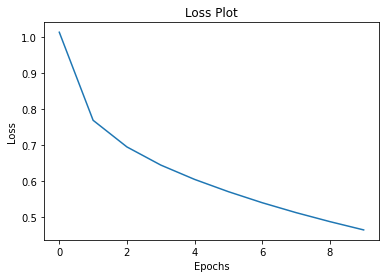

In [64]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam() 
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Initialisation de l'époque de début d’entrainement dans `start_epoch`. 
# La classe `tf.train.Checkpoint` permet de poursuivre l’entrainement là ou vous l’avez laissé s’il avait été interrompu auparavant.
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)
    
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

# Cette boucle d'entrainement parcours le jeu de données d'entrainement batch par batch et entraine le réseaux avec ceux-ci.
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'
                   .format(
                       epoch + 1, 
                       batch, 
                       batch_loss.numpy() / int(target.shape[1])
                   ))
    
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()
        
    # print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [65]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    attention_plot = attention_plot[:len(result), :]
    
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [66]:
def save_picture_to_output(img, result):
    # Remove the ''<end>' from the titles
    result = filter(lambda x: x != '<end>', result)
    # Remove the ''<unk>' from the titles
    result = filter(lambda x: x != '<unk>', result)
    # Remove the '\n' from the titles
    result = filter(lambda x: x != '\n', result)
    
    # Move the image with his result as name to output folder
    dest_path = captioning_output_path + '/' + img + ' - ' + ' '.join(result) + '.jpg'
    shutil.copy(image_path, dest_path)

In [91]:
# Evaluate all the pictures into the "input" folder
for img in os.listdir(treatments_output_path):
    image_path = treatments_output_path + '/' + img
    
    # Evaluate the given image
    result, attention_plot = evaluate(image_path)
    print(img, 'Prediction Caption:', ' '.join(result))

    # Give the details of the word founded
    # plot_attention(image_path, result, attention_plot)

    # Save image into output folder
    save_picture_to_output(img, result)

photo_0077.jpg Prediction Caption: a computer mouse sits in front of a passenger computer <end>
photo_0193.jpg Prediction Caption: a person on the air floating down the water skiing <end>
photo_0197.jpg Prediction Caption: a person riding a snowboard in the snow on a long snowboard on top of a steep mountain <end>
photo_0292.jpg Prediction Caption: a woman wearing a pair of food <end>
photo_0364.jpg Prediction Caption: two giraffes eating food <end>
photo_0499.jpg Prediction Caption: a basketball player in red t shirt runs with tennis racket <end>
photo_0619.jpg Prediction Caption: the train is traveling on town next to a lot <end>
